In [8]:
import geopandas as gpd
from snow_processing import clip_weekly_to_roi

# 1) Load & reproject your Lombardy ROI geojson
roi = gpd.read_file("F:/GeoinformaticsProject/Data/Lombardy.geojson")
roi = roi.to_crs("EPSG:32632")
shapes = [feature["geometry"] for feature in roi.__geo_interface__["features"]]

# 2) Point to your already‐aligned weekly folders
weekly_dirs = {
  "MODIS": r"F:/GeoinformaticsProject/Data/Processed/WEEKLY/MODIS",
  "GFSC" : r"F:\GeoinformaticsProject\Data\Processed\ALIGNED\GFSC",
  "S2"   : r"F:\GeoinformaticsProject\Data\Processed\ALIGNED/S2",
  "S3"   : r"F:\GeoinformaticsProject\Data\Processed\ALIGNED/S3_BINARY",
}


# 3) Only clip the common weeks you care about
common_weeks = [
    '2022_W02','2022_W04','2022_W06','2022_W07','2022_W08',
    '2022_W09','2022_W10','2022_W11','2022_W12','2022_W44',
    '2022_W47','2022_W49','2022_W50',
    '2023_W04','2023_W06','2023_W08','2023_W09','2023_W10',
    '2023_W11','2023_W13','2023_W14','2023_W15','2023_W17',
]

# 4) Where to write the clipped rasters
clipped_root = r"F:/GeoinformaticsProject/Data/Processed/CLIPPED"

# 5) Run it!
clip_weekly_to_roi(weekly_dirs, shapes, common_weeks, clipped_root)


🏷  Clipped MODIS 2022_W02 → F:/GeoinformaticsProject/Data/Processed/CLIPPED\MODIS\2022_W02.tif
🏷  Clipped MODIS 2022_W04 → F:/GeoinformaticsProject/Data/Processed/CLIPPED\MODIS\2022_W04.tif
🏷  Clipped MODIS 2022_W06 → F:/GeoinformaticsProject/Data/Processed/CLIPPED\MODIS\2022_W06.tif
🏷  Clipped MODIS 2022_W07 → F:/GeoinformaticsProject/Data/Processed/CLIPPED\MODIS\2022_W07.tif
🏷  Clipped MODIS 2022_W08 → F:/GeoinformaticsProject/Data/Processed/CLIPPED\MODIS\2022_W08.tif
🏷  Clipped MODIS 2022_W09 → F:/GeoinformaticsProject/Data/Processed/CLIPPED\MODIS\2022_W09.tif
🏷  Clipped MODIS 2022_W10 → F:/GeoinformaticsProject/Data/Processed/CLIPPED\MODIS\2022_W10.tif
🏷  Clipped MODIS 2022_W11 → F:/GeoinformaticsProject/Data/Processed/CLIPPED\MODIS\2022_W11.tif
🏷  Clipped MODIS 2022_W12 → F:/GeoinformaticsProject/Data/Processed/CLIPPED\MODIS\2022_W12.tif
🏷  Clipped MODIS 2022_W44 → F:/GeoinformaticsProject/Data/Processed/CLIPPED\MODIS\2022_W44.tif
🏷  Clipped MODIS 2022_W47 → F:/GeoinformaticsProje

In [5]:
import rasterio
import numpy as np
paths = {
    "modis" : r"F:\GeoinformaticsProject\Data\Processed\CLIPPED/MODIS/2023_W08.tif",
    "s2"    : r"F:\GeoinformaticsProject\Data\Processed\CLIPPED/S2/2023_W08.tif",
    "s3"    : r"F:\GeoinformaticsProject\Data\Processed\CLIPPED/S3/2023_W08.tif",
    "gfsc"  : r"F:\GeoinformaticsProject\Data\Processed\CLIPPED/GFSC/2023_W08.tif"
}

for name, p in paths.items():
    with rasterio.open(p) as src:
        print(f"{name}:")
        print("  width, height   →", src.width, src.height)
        print("  transform       →", src.transform)
        print("  CRS             →", src.crs)
        print("  nodata value    →", src.nodata)
        vals = src.read(1)
        print("  unique values   →", np.unique(vals)[-5:], "\n")  # show highest few


modis:
  width, height   → 11543 10898
  transform       → | 20.00, 0.00, 460645.15|
| 0.00,-20.00, 5165386.74|
| 0.00, 0.00, 1.00|
  CRS             → EPSG:32632
  nodata value    → 255.0
  unique values   → [  1 255] 

s2:
  width, height   → 11543 10898
  transform       → | 20.00, 0.00, 460645.15|
| 0.00,-20.00, 5165386.74|
| 0.00, 0.00, 1.00|
  CRS             → EPSG:32632
  nodata value    → 255.0
  unique values   → [  0   1 255] 

s3:
  width, height   → 11543 10898
  transform       → | 20.00, 0.00, 460645.15|
| 0.00,-20.00, 5165386.74|
| 0.00, 0.00, 1.00|
  CRS             → EPSG:32632
  nodata value    → 255.0
  unique values   → [  0   1 255] 

gfsc:
  width, height   → 11543 10898
  transform       → | 20.00, 0.00, 460645.15|
| 0.00,-20.00, 5165386.74|
| 0.00, 0.00, 1.00|
  CRS             → EPSG:32632
  nodata value    → 255.0
  unique values   → [  0   1 255] 



In [9]:
import rasterio
import numpy as np

# adjust these paths to one 2022_W07 tile at each stage:
paths = {
    "1. raw MODIS (original L1C)":  r"F:\GeoinformaticsProject\Data\MODIS_SnowMask\2022\neve_20220513.img",
    "2. resampled → EPSG:32632":     r"F:\GeoinformaticsProject\Data\Processed\RESAMPLED-REPROJECTED\MODIS\neve_20220101.tif",
    "3. weekly aggregate (2022_W07)":r"F:\GeoinformaticsProject\Data\Processed\WEEKLY\MODIS/2022_W44.tif",
    "4. clipped (2022_W07)":         r"F:/GeoinformaticsProject/Data/Processed/CLIPPED/MODIS/2022_W44.tif",
}

for stage, p in paths.items():
    try:
        with rasterio.open(p) as src:
            vals = np.unique(src.read(1))
        print(f"{stage:30s} → {vals}")
    except Exception as e:
        print(f"{stage:30s} → ERROR: {e}")


1. raw MODIS (original L1C)    → [1 2]
2. resampled → EPSG:32632      → [0 1 2]
3. weekly aggregate (2022_W07) → [  0   1 255]
4. clipped (2022_W07)          → [  1 255]


In [16]:
import rasterio
import numpy as np

# adjust these paths to one 2022_W07 tile at each stage:
paths = {
    "1. raw GFSC (original L1C)":  r"F:\GeoinformaticsProject\Data\GFSC\GFSC\20211121\20211121_GF.tif",
    "2. resampled → EPSG:32632":     r"F:\GeoinformaticsProject\Data\Processed\RESAMPLED-REPROJECTED\GFSC\20211205.tif",
    "3. weekly aggregate (2022_W07)":r"F:\GeoinformaticsProject\Data\Processed\WEEKLY\GFSC/2022_W44.tif",
    "4. Aligned (2022_W44)":         r"F:\GeoinformaticsProject\Data\Processed\ALIGNED/GFSC\2022_W44.tif",
    "5. clipped (2022_W07)":         r"F:/GeoinformaticsProject/Data/Processed/CLIPPED/GFSC/2022_W44.tif",
}

for stage, p in paths.items():
    try:
        with rasterio.open(p) as src:
            vals = np.unique(src.read(1))
        print(f"{stage:30s} → {vals}")
    except Exception as e:
        print(f"{stage:30s} → ERROR: {e}")


1. raw GFSC (original L1C)     → [  0   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23
  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41
  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 205 255]
2. resampled → EPSG:32632      → [  0   1 255]
3. weekly aggregate (2022_W07) → [  0   1 255]
4. Aligned (2022_W44)          → [0 1]
5. clipped (2022_W07)          → [  0   1 255]


In [3]:
import rasterio
import numpy as np

# adjust these paths to one 2022_W07 tile at each stage:
paths = {
    "1. raw S2 ":  r"F:\GeoinformaticsProject\Data\S2\S2\SnowMask\20220103_20220116_SnowMask_latest.tif",
    "2. resampled → EPSG:32632":     r"F:\GeoinformaticsProject\Data\Processed\RESAMPLED-REPROJECTED\S2\2022_W40.tif",
    "3. Aligned (2022_W44)":         r"F:\GeoinformaticsProject\Data\Processed\ALIGNED/S2\2022_W44.tif",
    "4. clipped (2022_W07)":         r"F:\GeoinformaticsProject\Data\Processed\CLIPPED\S2\2022_W07.tif",
}

for stage, p in paths.items():
    try:
        with rasterio.open(p) as src:
            vals = np.unique(src.read(1))
        print(f"{stage:30s} → {vals}")
    except Exception as e:
        print(f"{stage:30s} → ERROR: {e}")


1. raw S2                      → [0 1]
2. resampled → EPSG:32632      → [  1 255]
3. Aligned (2022_W44)          → [0 1]
4. clipped (2022_W07)          → [  0   1 255]


In [12]:
import rasterio
import numpy as np

# adjust these paths to one 2022_W07 tile at each stage:
paths = {
    "1. raw S3 ":  r"F:\GeoinformaticsProject\Data\S3\S3\SnowMask\20220103_20220109_SnowMask(0.42)_latest.tif",
    "2. resampled → EPSG:32632":     r"F:\GeoinformaticsProject\Data\Processed\RESAMPLED-REPROJECTED\S3\2022_W03.tif",
    "3. Aligned (2022_W44)":         r"F:\GeoinformaticsProject\Data\Processed\ALIGNED\S3_BINARY\2022_W44.tif",
    "4. clipped (2022_W07)":         r"F:\GeoinformaticsProject\Data\Processed\CLIPPED\S3\2022_W07.tif",
}

for stage, p in paths.items():
    try:
        with rasterio.open(p) as src:
            vals = np.unique(src.read(1))
        print(f"{stage:30s} → {vals}")
    except Exception as e:
        print(f"{stage:30s} → ERROR: {e}")


1. raw S3                      → [0 1]
2. resampled → EPSG:32632      → [0 1 2 3 4 5 6 7]
3. Aligned (2022_W44)          → [0 1]
4. clipped (2022_W07)          → [  0   1 255]


In [7]:
import rasterio
import numpy as np

path = r"F:/GeoinformaticsProject/Data/Processed/CLIPPED/MODIS/2022_W44.tif"
with rasterio.open(path) as src:
    arr = src.read(1)

# count how many 0, 1, and nodata (255) pixels
uniq, counts = np.unique(arr, return_counts=True)
for v, c in zip(uniq, counts):
    label = {0: "zero (no-snow)",
             1: "one  (snow)",
           255: "nodata/outside ROI"}.get(v, v)
    print(f"{label:15s} → {c:,} pixels")


one  (snow)     → 59,653,061 pixels
nodata/outside ROI → 66,142,553 pixels


In [9]:
from snow_processing import compute_weekly_statistics


# 1) Define where your clipped files live and which products to include
clipped_root = r"F:/GeoinformaticsProject/Data/Processed/CLIPPED"
products     = ["MODIS", "GFSC", "S2", "S3"]

# 2) Run the stats function
df_stats = compute_weekly_statistics(clipped_root, products, pixel_size=20.0)

# 3) Inspect the first few rows
print(df_stats.head())


  product      week  total_pixels  snow_pixels  missing_pixels  snow_area_km2  \
0    GFSC  2022_W07      59653061      4649496        66142553      1859.7984   
1   MODIS  2022_W07      59653061     59653061        66142553     23861.2244   
2      S2  2022_W07      59653061      8667788        66142553      3467.1152   
3      S3  2022_W07      59653061     12428916        66142553      4971.5664   
4    GFSC  2022_W09      59653061      2273490        66142553       909.3960   

   coverage_pct  
0      7.794229  
1    100.000000  
2     14.530332  
3     20.835337  
4      3.811187  


In [11]:
from snow_processing import compute_pairwise_agreement

# 1) Point at your **clipped** folders, not the aligned ones:
clipped_root  = r"F:/GeoinformaticsProject/Data/Processed/CLIPPED"
products      = ["MODIS", "GFSC", "S2", "S3"]
common_weeks  = [
    '2022_W07', '2022_W09', '2022_W11',
    '2022_W44', '2022_W49', '2022_W50',
    '2023_W04', '2023_W06', '2023_W08',
    '2023_W09', '2023_W10', '2023_W11',
    '2023_W13', '2023_W14', '2023_W15', '2023_W17'
]

# 2) Run agreement on clipped Lombardy‐only files
df_agree = compute_pairwise_agreement(clipped_root, products, common_weeks)

# 3) Verify it’s non‐empty and has the “week” column
print(df_agree.shape)
print(df_agree.columns)
print(df_agree.head())


(96, 11)
Index(['week', 'prod1', 'prod2', 'agreement_pct', 'total_pixels',
       'agree_pixels', 'p1_only_pixels', 'p2_only_pixels', 'p1_only_area_km2',
       'p2_only_area_km2', 'area_bias_km2'],
      dtype='object')
       week  prod1 prod2  agreement_pct  total_pixels  agree_pixels  \
0  2022_W07   GFSC    S2      88.637562      59653061      52875019   
1  2022_W07   GFSC    S3      79.640401      59653061      47507937   
2  2022_W07  MODIS  GFSC       7.794229      59653061       4649496   
3  2022_W07  MODIS    S2      14.530332      59653061       8667788   
4  2022_W07  MODIS    S3      20.835337      59653061      12428916   

   p1_only_pixels  p2_only_pixels  p1_only_area_km2  p2_only_area_km2  \
0         1379875         5398167          551.9500         2159.2668   
1         2182852         9962272          873.1408         3984.9088   
2        55003565               0        22001.4260            0.0000   
3        50985273               0        20394.1092         

In [14]:
# Quick check on S2 vs S3
print(df_agree.query("prod1=='S2' and prod2=='S3'")[["week","agreement_pct"]])

        week  agreement_pct
5   2022_W07      85.666275
11  2022_W09      94.514188
17  2022_W11      96.005865
23  2022_W44      91.571624
29  2022_W49      83.387704
35  2022_W50      79.195059
41  2023_W04      89.232128
47  2023_W06      91.004539
53  2023_W08      95.901768
59  2023_W09      93.532052
65  2023_W10      89.152632
71  2023_W11      91.931306
77  2023_W13      94.329682
83  2023_W14      94.829942
89  2023_W15      90.125635
95  2023_W17      93.521870


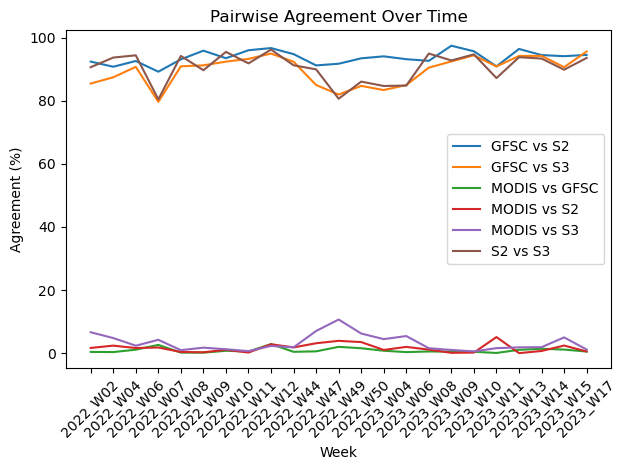

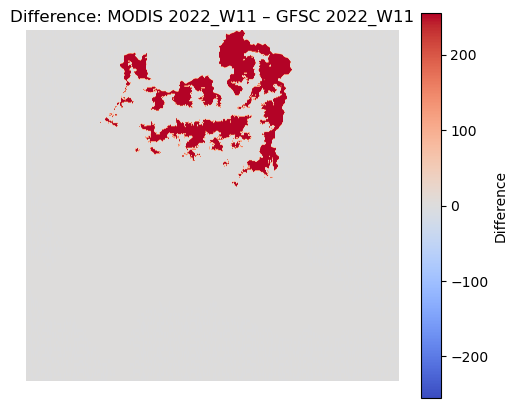

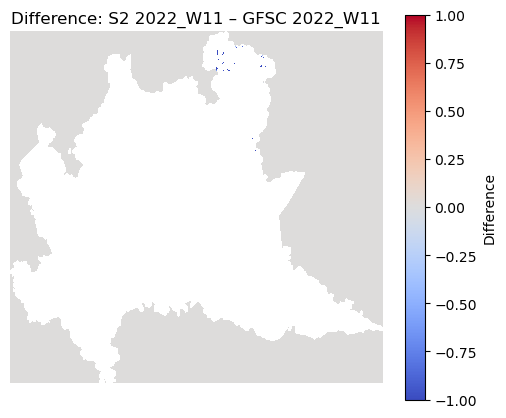

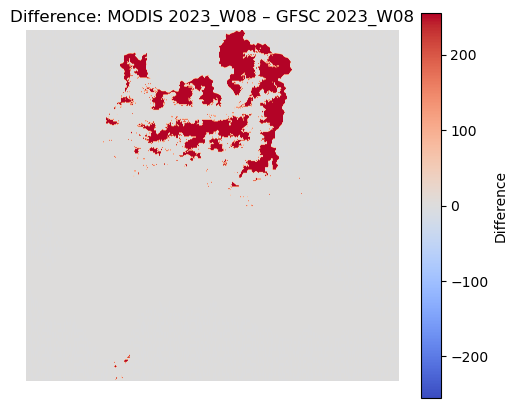

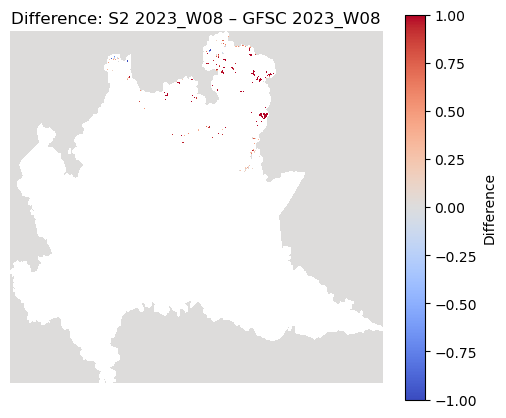

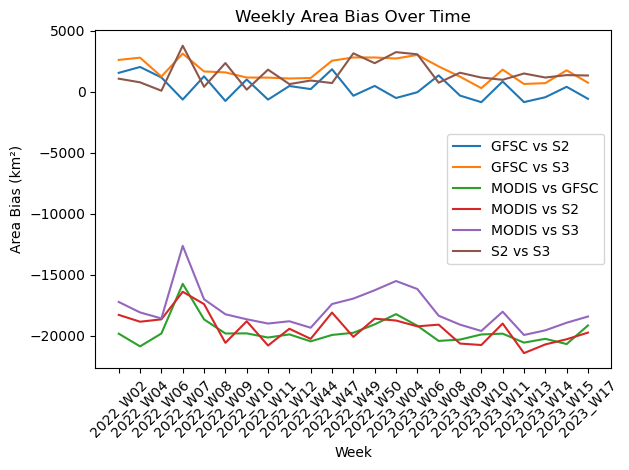

In [14]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from snow_processing import compute_pairwise_agreement

# 1) Paths and settings
clipped_root = r"F:/GeoinformaticsProject/Data/Processed/CLIPPED"
products     = ["MODIS", "GFSC", "S2", "S3"]
common_weeks = [
    '2022_W02','2022_W04','2022_W06','2022_W07','2022_W08',
    '2022_W09','2022_W10','2022_W11','2022_W12','2022_W44',
    '2022_W47','2022_W49','2022_W50',
    '2023_W04','2023_W06','2023_W08','2023_W09','2023_W10',
    '2023_W11','2023_W13','2023_W14','2023_W15','2023_W17',
]
# 2) Compute pairwise agreement DataFrame
df_agree = compute_pairwise_agreement(clipped_root, products, common_weeks)

# 3) Time series of agreement_pct for all product pairs
df_ts = df_agree.pivot(index="week", columns=["prod1","prod2"], values="agreement_pct")
df_ts = df_ts.reindex(common_weeks)

plt.figure()
for pair in df_ts.columns:
    plt.plot(df_ts.index, df_ts[pair], label=f"{pair[0]} vs {pair[1]}")
plt.xticks(rotation=45)
plt.xlabel("Week")
plt.ylabel("Agreement (%)")
plt.title("Pairwise Agreement Over Time")
plt.legend()
plt.tight_layout()
plt.show()


# 4) Spatial difference maps for representative weeks
from snow_processing import visual_compare_rasters_strict

representative_weeks = ['2022_W11', '2023_W08']
pairs_to_map = [('MODIS','GFSC'), ('S2','GFSC')]

for week in representative_weeks:
    for p1, p2 in pairs_to_map:
        path1 = os.path.join(clipped_root, p1, f"{week}.tif")
        path2 = os.path.join(clipped_root, p2, f"{week}.tif")
        visual_compare_rasters_strict(
            raster_path1=path1,
            raster_path2=path2,
            labels=(f"{p1} {week}", f"{p2} {week}"),
            difference=True,
            downsample=1
        )


# 5) Time series of area bias (km²) for all product pairs
df_bias = df_agree.pivot(index="week", columns=["prod1","prod2"], values="area_bias_km2")
df_bias = df_bias.reindex(common_weeks)

plt.figure()
for pair in df_bias.columns:
    plt.plot(df_bias.index, df_bias[pair], label=f"{pair[0]} vs {pair[1]}")
plt.xticks(rotation=45)
plt.xlabel("Week")
plt.ylabel("Area Bias (km²)")
plt.title("Weekly Area Bias Over Time")
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
# show the raw numbers, not the plotted line
print(
    df_agree
      .query("prod1 == 'S2' and prod2 == 'S3'")
      .loc[:, ["week","agreement_pct","p1_only_pixels","p2_only_pixels"]]
)


        week  agreement_pct  p1_only_pixels  p2_only_pixels
5   2022_W07      85.666275         2394689         6155817
11  2022_W09      94.514188         1356562         1915893
17  2022_W11      96.005865         1164885         1217739
23  2022_W44      91.571624         2500186         2527598
29  2022_W49      83.387704         7175674         2734069
35  2022_W50      79.195059        12364329           46455
41  2023_W04      89.232128         3554515         2868850
47  2023_W06      91.004539         2236528         3129540
53  2023_W08      95.901768          691253         1753468
59  2023_W09      93.532052         1370209         2488120
65  2023_W10      89.152632         5973677          497110
71  2023_W11      91.931306         3382335         1430888
77  2023_W13      94.329682         1960342         1422176
83  2023_W14      94.829942         1985920         1098178
89  2023_W15      90.125635         2025226         3865135
95  2023_W17      93.521870         2537